<a href="https://colab.research.google.com/github/VincentGaoHJ/Course-CS5242/blob/master/practice_5_convolutionalNeuralNetworks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Practice 5: Convolutional Neural Networks

In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torchvision import datasets, transforms
from tqdm.notebook import tqdm
import torchvision

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

device = torch.device('cuda:0')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


**In this tutorial, we will learn about convolutional neural networks (CNNs). We will work on the MNIST dataset and make the last tutorials model better by using convolutional neural nets.**

Just like the last tutorial, we will start by defining the MNIST dataset. 

In [ ]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]) 
trainset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=100, shuffle=True)

testset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False)

Q1. Initialize an MNist dataloader just like the last tutorial. Create a neural network model for classification with 


*   Convolution layer (16 channels, 3x3 kernel, stride 1, no padding)
*   Max-pooling layer (2x2 kernel, stride 1, no padding)
*   ReLU activation
*   Fully connected layer

Print the number of parameters for this network. Use cross-entropy loss, adam optimizer and train the model with multiple passes through the data and check the accuracy on the test set.


In [ ]:
class Net(nn.Module):
    """
    Convolutional neural network
    """
    def __init__(self):
        # Creates an instance of the base nn.Module class
        super(Net, self).__init__() # Inheritance of the base class nn.Module
        # Convolution layer: 16 channels (output), 3x3 kernel, stride 1, no padding
        # First convolution size changes from (1, 28, 28) to (16, 26, 26)
        self.conv = nn.Conv2d(
            in_channels=1, out_channels=16, 
            kernel_size=3, stride=1, padding=0) 
        # Max-pooling layer (2x2 kernel, stride 1, no padding)
        # Size of the dimension changes from (16, 26, 26) to (16, 25, 25)
        self.pool = nn.MaxPool2d(
            kernel_size = 2, stride = 1, 
            padding = 0)
        # Fully connected layer: 10 output features for 10 defined classes
        self.fc = nn.Linear(16 * 25 * 25, 10)   

    def forward(self, x):
        # Input size: (1, 28, 28)
        x = F.relu(self.conv(x)) # Size changes to (16, 26, 26)
        x = self.pool(x) # Size changes to (16, 25, 25)
        x = x.view(-1, 16 * 25 * 25) # Size changes to (1, 16 * 25 *25)
        x = self.fc(x) # Size changes to (1, 10)
        return x

In [ ]:
MnistNet = Net().to(device)
pytorch_total_params = sum(p.numel() for p in MnistNet.parameters())
print(f'Number of parameter is {pytorch_total_params}')

Number of parameter is 100170


In [ ]:
def accuracy(model, dataloader, device):
    correct = 0
    total = 0
    for idx, (images, labels) in enumerate(dataloader):
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        with torch.no_grad():
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

def train_model_one_pass(p_network, criterion, p_optim, trainloader, testloader, epoch=1, log_interval=100):
    p_network.train()
    acc_one_pass, loss_one_pass = [], []
    running_loss = 0.0
    for idx, (images, labels) in enumerate(trainloader):
        # Move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        model_out = p_network(images)
        loss = criterion(model_out, labels) # Get loss using outputs and ground truth labels.
        
        # Backprpagation and optimization
        p_optim.zero_grad() # remember to clear grads before calling gradients
        loss.backward() # Call backward on the loss ()
        p_optim.step() # Call optimizer.step to perform SGD update. 

        # print statistics
        running_loss += loss.item()
        if idx % log_interval == log_interval-1:
            print('Epoch {} \t Iter: {}/{} ({:.2f}%) \t Train Loss: {:.4f}'.format(
                epoch, (idx+1) * len(images), len(trainset), 
                100.*(idx+1) * len(images)/len(trainset), running_loss / log_interval))
            running_loss = 0.0
    
    acc = accuracy(p_network, testloader, device)
    print('Test on Epoch: {} \t Accuracy: {:.2f}%'.format(
        epoch, acc).center(76, '='))

MnistNet = Net().to(device)
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(MnistNet.parameters(), lr=0.01) 
# Train and test the model
train_model_one_pass(MnistNet, criterion, optimizer, trainloader, testloader)

Epoch 1 	 Iter: 10000/60000 (16.67%) 	 Train Loss: 1.8790
Epoch 1 	 Iter: 20000/60000 (33.33%) 	 Train Loss: 0.1759
Epoch 1 	 Iter: 30000/60000 (50.00%) 	 Train Loss: 0.1320
Epoch 1 	 Iter: 40000/60000 (66.67%) 	 Train Loss: 0.1214
Epoch 1 	 Iter: 50000/60000 (83.33%) 	 Train Loss: 0.1023
Epoch 1 	 Iter: 60000/60000 (100.00%) 	 Train Loss: 0.0875
====================Test on Epoch: 1 	 Accuracy: 97.68%=====================


In [ ]:
def train_model(model, criterion, optimizer, trainloader, testloader, num_epochs=10, log_interval=300):
    model.train()
    running_loss = 0.0
    for epoch in range(1, num_epochs + 1):
        for idx, (images, labels) in enumerate(trainloader):
            # Move tensors to the configured device
            images = images.to(device)
            labels = labels.to(device)
            
            # Forward pass
            model_out = model(images)
            loss = criterion(model_out, labels) # Get loss using outputs and ground truth labels.
            
            # Backprpagation and optimization
            optimizer.zero_grad() # remember to clear grads before calling gradients
            loss.backward() # Call backward on the loss ()
            optimizer.step() # Call optimizer.step to perform SGD update. 

            # print statistics
            running_loss += loss.item()
            if idx % log_interval == log_interval-1:
                print('Epoch {} \t Iter: {}/{} ({:.2f}%) \t Train Loss: {:.4f}'.format(
                    epoch, (idx+1) * len(images), len(trainset), 
                    100.*(idx+1) * len(images)/len(trainset), running_loss / log_interval))
                running_loss = 0.0
        
        acc = accuracy(model, testloader, device)
        print('Test on Epoch: {} \t Accuracy: {:.2f}%'.format(
            epoch, acc).center(76, '='))

In [ ]:
MnistNet = Net().to(device)
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(MnistNet.parameters(), lr=0.001) 
# Train and test the model
train_model(MnistNet, criterion, optimizer, trainloader, testloader, num_epochs=5)

Epoch 1 	 Iter: 30000/60000 (50.00%) 	 Train Loss: 0.3370
Epoch 1 	 Iter: 60000/60000 (100.00%) 	 Train Loss: 0.1300
====================Test on Epoch: 1 	 Accuracy: 97.07%=====================
Epoch 2 	 Iter: 30000/60000 (50.00%) 	 Train Loss: 0.0904
Epoch 2 	 Iter: 60000/60000 (100.00%) 	 Train Loss: 0.0823
====================Test on Epoch: 2 	 Accuracy: 97.55%=====================
Epoch 3 	 Iter: 30000/60000 (50.00%) 	 Train Loss: 0.0616
Epoch 3 	 Iter: 60000/60000 (100.00%) 	 Train Loss: 0.0674
====================Test on Epoch: 3 	 Accuracy: 98.00%=====================
Epoch 4 	 Iter: 30000/60000 (50.00%) 	 Train Loss: 0.0521
Epoch 4 	 Iter: 60000/60000 (100.00%) 	 Train Loss: 0.0521
====================Test on Epoch: 4 	 Accuracy: 97.65%=====================
Epoch 5 	 Iter: 30000/60000 (50.00%) 	 Train Loss: 0.0419
Epoch 5 	 Iter: 60000/60000 (100.00%) 	 Train Loss: 0.0457
====================Test on Epoch: 5 	 Accuracy: 98.20%=====================


Q2. For a random sample of 5 digits (different digits), plot the first 10 convolution layer outputs (first 10 channels) and check it. (Tips: Use the member module, e.g., Net.conv1, or the hook)


In [ ]:
def hook(self, input, output):
    # input is a tuple of packed inputs
    # output is a Tensor. output.data is the Tensor we are interested
    features.append(output.clone().detach())



# Select a random sample of 5 digits
label_lst = []
image_lst = []
images, labels = next(iter(trainloader))
for image, label in zip(images, labels):
    if len(label_lst) >= 5:
        break
    if label.item() in label_lst:
        continue
    
    label_lst.append(label.item())
    image_lst.append(image)


# Stack five image as input
images = torch.stack(image_lst).to(device)

# clear hook outpuy
features = []

# Initiate Network
MnistNet = Net().to(device)

# Save intermediate feature maps by saving the feature maps to a python variable external to the hook function
feature_handle = MnistNet.conv.register_forward_hook(hook)
out = MnistNet(images)
intermediate_res = features[0]

# remove handle
feature_handle.remove()

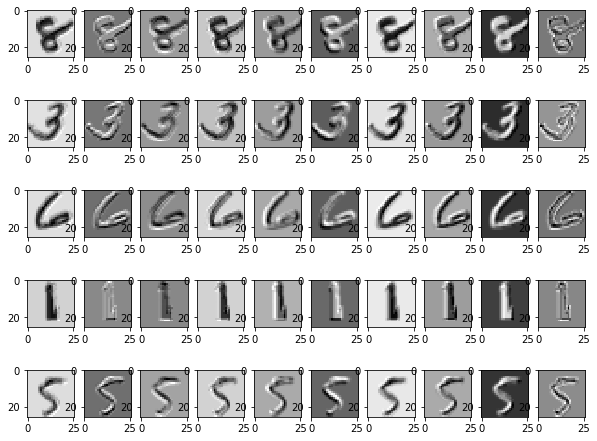

In [ ]:
def visualize_images(label_lst, intermediate_res, num_channel=10):
    for idx, label_num in enumerate(label_lst):
        for channel_idx in range(num_channel):
            plt.subplot(len(label_lst), num_channel, idx*num_channel+channel_idx+1)
            plt.imshow(torch.squeeze(intermediate_res.cpu()[idx, channel_idx, :, :]))
            # plt.axis('off')
    
visualize_images(label_lst, intermediate_res)

Q3. Use the first network from Q1 and then stack another layer of convolution after the max-pooling layer with a ReLU in between. Increase the number of channels to 64 for the next layer while keeping the kernel size to 3x3. Add batch norm and dropouts to your network. Print the parameter size. Train the network and print test accuracy.


In [ ]:
class Net(nn.Module):
    """
    Convolutional neural network
    """
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=0) 
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=64, kernel_size=3, stride=1, padding=0) 
        self.pool = nn.MaxPool2d(kernel_size = 2, stride = 1, padding = 0)
        self.conv2_bn = nn.BatchNorm2d(num_features=64)
        self.drop_out = nn.Dropout()
        self.fc = nn.Linear(64 * 23 * 23, 10)   

    def forward(self, x):
        # Input size: (1, 28, 28)
        x = F.relu(self.conv1(x)) # Size changes to (16, 26, 26)
        x = F.relu(self.pool(x)) # Size changes to (16, 25, 25)
        x = self.conv2(x) # Size changes to (64, 23, 23)
        x = self.conv2_bn(x)
        x = self.drop_out(x)
        x = x.view(-1, 64 * 23 * 23) # Size changes to (1, 64 * 23 * 23)
        x = self.fc(x) # Size changes to (1, 10)
        return x

In [ ]:
MnistNet = Net().to(device)
pytorch_total_params = sum(p.numel() for p in MnistNet.parameters())
print(f'Number of parameter is {pytorch_total_params}')

Number of parameter is 348138


In [ ]:
MnistNet = Net().to(device)
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(MnistNet.parameters(), lr=0.001) 
# Train and test the model
train_model(MnistNet, criterion, optimizer, trainloader, testloader, num_epochs=5)

Epoch 1 	 Iter: 30000/60000 (50.00%) 	 Train Loss: 0.4081
Epoch 1 	 Iter: 60000/60000 (100.00%) 	 Train Loss: 0.3350
====================Test on Epoch: 1 	 Accuracy: 97.06%=====================
Epoch 2 	 Iter: 30000/60000 (50.00%) 	 Train Loss: 0.2573
Epoch 2 	 Iter: 60000/60000 (100.00%) 	 Train Loss: 0.2247
====================Test on Epoch: 2 	 Accuracy: 97.10%=====================
Epoch 3 	 Iter: 30000/60000 (50.00%) 	 Train Loss: 0.1639
Epoch 3 	 Iter: 60000/60000 (100.00%) 	 Train Loss: 0.1670
====================Test on Epoch: 3 	 Accuracy: 97.42%=====================
Epoch 4 	 Iter: 30000/60000 (50.00%) 	 Train Loss: 0.1250
Epoch 4 	 Iter: 60000/60000 (100.00%) 	 Train Loss: 0.1248
====================Test on Epoch: 4 	 Accuracy: 97.88%=====================
Epoch 5 	 Iter: 30000/60000 (50.00%) 	 Train Loss: 0.0841
Epoch 5 	 Iter: 60000/60000 (100.00%) 	 Train Loss: 0.0934
====================Test on Epoch: 5 	 Accuracy: 97.72%=====================


Q4. Visualize wrong predictions.  An important way to gain intuition about how the algorithm works are to visualize the mistakes that it makes. In this visualization, we show examples of images that are misclassified by our current system. 


In [ ]:
def find_wrong_image(model, dataloader, device):
    wrong_images = []
    predictions = []
    for _, (images, labels) in enumerate(dataloader):
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        with torch.no_grad():
            _, predicted = torch.max(outputs.data, 1)
            for image, predict, label in zip(images, predicted, labels):
                if predict != label:
                    wrong_images.append(image)
                    predictions.append(predict.item())
    return wrong_images, predictions

wrong_images, predictions = find_wrong_image(MnistNet, testloader, device)

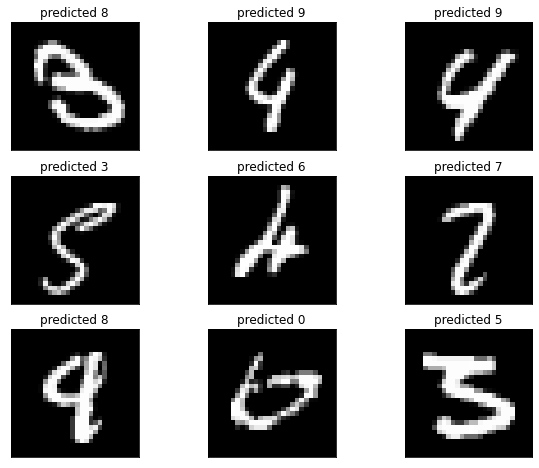

In [ ]:
wrong_images_9 = wrong_images[:10]
predictions_9 = predictions[:10]

from matplotlib import pyplot as plt
fig, axes = plt.subplots(nrows=3, ncols=3)

for i in range(9):
  plt.subplot(3, 3, i+1)
  plt.imshow(wrong_images_9[i].cpu()[0])
  plt.title('predicted '+str(predictions_9[i]))
  plt.xticks([])
  plt.yticks([])

Q5. Use the pytorch pre-trained resnet18 model with fine-tuning to classify Cifar10 data and print its train and test accuracy.

**Hint**:

- Using Pytorch pre-trained resnet18 model: [https://pytorch.org/docs/stable/torchvision/models.html](https://pytorch.org/docs/stable/torchvision/models.html).

- For fine-tuning, you can have a look at [How to fine-tune your artificial intelligence algorithms](https://www.allerin.com/blog/how-to-fine-tune-your-artificial-intelligence-algorithms).


In [ ]:
from torchvision.models import resnet18

def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

def initialize_model(num_classes, feature_extract, use_pretrained=True):
    model_ft = resnet18(pretrained=use_pretrained)
    set_parameter_requires_grad(model_ft, feature_extract)
    num_ftrs = model_ft.fc.in_features
    model_ft.fc = nn.Linear(num_ftrs, num_classes)
    input_size = 224
    return model_ft, input_size

In [ ]:
# Flag for feature extracting. When False, we finetune the whole model, 
feature_extract = False # when True we only update the reshaped layer params

# Initialize the model for this run
cifar10_resnet, input_size = initialize_model(10, feature_extract, use_pretrained=True)

# Print the model we just instantiated
print(cifar10_resnet)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
# Implement transfer learning is to simply take an already existing model and reuse it, tuning its parameters and hyperparameters as you do so.
# The Resnet model was developed and trained on an ImageNet dataset as well as the CIFAR-10 dataset.
transform = transforms.Compose(
    [transforms.Resize(input_size), # Input as denoted above
     transforms.CenterCrop(input_size),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Loading and normalizing CIFAR10
trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=4, shuffle=True, num_workers=2)
testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=4, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 
           'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

cifar10_resnet = cifar10_resnet.to(device)
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cifar10_resnet.parameters(), lr=0.001) 
# Train and test the model
train_model(cifar10_resnet, criterion, optimizer, trainloader, testloader, num_epochs=5, log_interval=3000)

Epoch 1 	 Iter: 12000/50000 (24.00%) 	 Train Loss: 1.4685
Epoch 1 	 Iter: 24000/50000 (48.00%) 	 Train Loss: 1.2246
Epoch 1 	 Iter: 36000/50000 (72.00%) 	 Train Loss: 1.0435
Epoch 1 	 Iter: 48000/50000 (96.00%) 	 Train Loss: 0.9244
====================Test on Epoch: 1 	 Accuracy: 69.60%=====================
Epoch 2 	 Iter: 12000/50000 (24.00%) 	 Train Loss: 0.9309
Epoch 2 	 Iter: 24000/50000 (48.00%) 	 Train Loss: 0.7364
